<a href="https://colab.research.google.com/github/Riky2014/Tesi/blob/main/1d_hemo_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt-get install software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install fenics

In [2]:
import logging
import numpy as np
from fenics import *
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the logging level to suppress FFC messages
logging.getLogger('UFL_LEGACY').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.ERROR)
set_log_level(LogLevel.ERROR)

# Data, Mesh and Function spaces

In [233]:
# Data
x_left = 0.
x_right = 1.0

A_tilde = 4e-4
a_tilde = 4e-5
q_tilde = 0.0
K_tilde = 50e3

alpha = 1
k_r = 2.416e-4
rho = 1.05

T = 1
L = 1

# Discretization parameter
dt = 1e-5
h = 1 / 256
num_steps = T / dt
N = int((x_right - x_left) / h)

# Create a mesh on the interval [0, 1].
mesh = IntervalMesh(N, x_left, x_right)
x = MeshCoordinates(mesh)

# Define the function space
P1 = FiniteElement('P', mesh.ufl_cell(), 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Derivative function space
D1 = FiniteElement('DG', mesh.ufl_cell(), 0)
element_der = MixedElement([D1, D1])
V_der = FunctionSpace(mesh, element_der)

# Define the function space for exact solution
P2 = FiniteElement('P', mesh.ufl_cell(), 2)
element_exact = MixedElement([P2, P2])
V_ex = FunctionSpace(mesh, element_exact)

# Exact solution and forcing term, sinusiodal

In [234]:
# Exact solution and forcing term

A_exact = Expression('A_tilde + a_tilde * sin(2 * pi / L * x[0]) * cos(2 * pi / T * t)', A_tilde = A_tilde, a_tilde = a_tilde, L = L, T = T, degree = 2, t = 0)

q_exact = Expression('q_tilde - (a_tilde * L / T) * cos(2 * pi / L * x[0]) * sin(2 * pi / T * t)', q_tilde = q_tilde, a_tilde = a_tilde, L = L, T = T, degree = 2, t = 0)

dU_dt = Expression(('- 2 * pi * a_tilde * sin(2 * pi * t) * sin(2 * pi * x[0])',

                    '- 2 * pi * a_tilde * L / T * cos(2 * pi * t) * cos(2 * pi * x[0])'),
                    a_tilde = a_tilde, L = L, T = T, degree = 1, t = 0)

S = Expression(('0.',

                'k_r * (q_tilde - (a_tilde * L / T) * cos(2 * pi / L * x[0]) * sin(2 * pi / T * t)) / (A_tilde + a_tilde * sin(2 * pi / L * x[0]) * cos(2 * pi / T * t))'),
                A_tilde = A_tilde, a_tilde = a_tilde, q_tilde = q_tilde, L = L, T = T, k_r = k_r, degree = 1, t = 0)

dF_dx = Expression(('2 * pi * a_tilde * L / T * sin(2 * pi * t) * sin(2 * pi * x[0])',

                    'pi * K_tilde * a_tilde / rho * pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 0.5) * cos(2 * pi * t) * cos(2 * pi * x[0]) \
                    - 2 * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 2) * cos(2 * pi * t) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 2) \
                    - 4 * pi * pow(a_tilde, 2) * pow(sin(2 * pi * t), 2) * sin(2 * pi * x[0]) * cos(2 * pi * x[0]) / (A_tilde + a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t))'),
                    a_tilde = a_tilde, A_tilde = A_tilde, K_tilde = K_tilde, L = L, T = T, rho = rho, degree = 1, t = 0)

dU_dt_dt = Expression(('- 4 * pi * pi * a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t)',

                       '4 * pi * pi * a_tilde * sin(2 * pi * t) * cos(2 * pi * x[0])'),
                       a_tilde = a_tilde, L = L, T = T, degree = 1, t = 0)

dS_dt = Expression(('0.',

                    '- 2 * pi * k_r * pow(a_tilde / A_tilde, 2) * pow(sin(2 * pi * t), 2) * sin(2 * pi * x[0]) * cos(2 * pi * x[0]) / (pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 2)) \
                    - 2 * pi * k_r * a_tilde * cos(2 * pi * t) * cos(2 * pi * x[0]) / (A_tilde + a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t))'),
                    A_tilde = A_tilde, a_tilde = a_tilde, q_tilde = q_tilde, L = L, T = T, k_r = k_r, degree = 1, t = 0)

dF_dx_dt = Expression(('4 * pi * pi * a_tilde * L / T * cos(2 * pi * t) * sin(2 * pi * x[0])',

                    '- 0.1 * pi * pi * K_tilde * a_tilde / rho * sin(2 * pi * t) * sin(2 * pi * x[0]) * cos(2 * pi * t) * cos(2 * pi * x[0]) / pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 0.5) \
                    - 2 * pi * pi * K_tilde * a_tilde / rho * pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 0.5) * sin(2 * pi * t) * cos(2 * pi * x[0]) \
                    - 8 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 3) * pow(sin(2 * pi * x[0]), 2) * cos(2 * pi * x[0]) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 2) \
                    + 4 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 3) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 2) \
                    - 8 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * sin(2 * pi * t) * pow(cos(2 * pi * t), 2) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 2) \
                    - 0.8 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 3) * sin(2 * pi * x[0]) * cos(2 * pi * t) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 3) \
                    - 16 * pi * pi * pow(a_tilde, 2) * sin(2 * pi * t) * sin(2 * pi * x[0]) * cos(2 * pi * t) * cos(2 * pi * x[0]) / (A_tilde + a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t))'),
                    a_tilde = a_tilde, A_tilde = A_tilde, K_tilde = K_tilde, L = L, T = T, rho = rho, degree = 1, t = 0)

f = dU_dt + S + dF_dx
f_n = project(f, V)

df_dt = dU_dt_dt + dS_dt + dF_dx_dt
df_dt_n = project(df_dt, V)

# Exact solution and forcing term, linear

In [178]:
# Exact solution and forcing term

A_exact = Expression('1 + x[0] * t', degree = 1, t = 0)

q_exact = Expression('x[0] * t', degree = 1, t = 0)

dU_dt = Expression(('x[0]', 'x[0]'), degree = 1, t = 0)

S = Expression(('0.', 'k_r * t * x[0] / (t * x[0] + 1)'), k_r = k_r , degree = 1, t = 0)

dF_dx = Expression(('t', '- pow(t, 3) * pow(x[0], 2) / pow(t * x[0] + 1, 2) + 2 * pow(t, 2) * x[0] / (t * x[0] + 1) + K_tilde / (2 * rho) * pow(t * x[0] + 1, 0.5)'), K_tilde = K_tilde, rho = rho, degree = 1, t = 0)

dU_dt_dt = Expression(('0.', '0.'), degree = 1, t = 0)

dS_dt = Expression(('0.', '- k_r * t * pow(x[0], 2) / pow(t * x[0] + 1, 2) + k_r * x[0] / (t * x[0] + 1)'), k_r = k_r, degree = 1, t = 0)

dF_dx_dt = Expression(('1',

                    '2 * pow(t, 3) * pow(x[0], 3) / pow(t * x[0] + 1, 3) \
                    - 5 * pow(t, 2) * pow(x[0], 2) / pow(t * x[0] + 1, 2) \
                    + K_tilde / (4 * rho) * t * x[0] / pow(t * x[0] + 1, 0.5) \
                    + 4 * t * x[0] / (t * x[0] + 1) \
                    + K_tilde / (2 * rho) * pow(t * x[0] + 1, 0.5)'),
                    K_tilde = K_tilde, rho = rho, degree = 1, t = 0)

f = dU_dt + S + dF_dx
f_n = project(f, V)

df_dt = dU_dt_dt + dS_dt + dF_dx_dt
df_dt_n = project(df_dt, V)

# Functions

In [235]:
def H(A, q):
  return as_tensor([[0, 1], [K_tilde / (2 * rho * A0 ** 0.5) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def F(A, q):
  return as_vector([q, K_tilde / (3 * rho * A0 ** 0.5) * A ** 1.5 - K_tilde / (3 * rho) * A0 + q ** 2 / A])

def B(A, q):
  return as_vector([0, k_r * q / A])

def S(A, q):
  return as_vector([0, k_r * q / A])

def dS_dU(A, q):
  return as_tensor([[0, 0], [- k_r * q / A ** 2, k_r / A]])

In [247]:
def U(A, q):
  return np.array([A, q])

def H_vec(A, q):
  return np.array([[0, 1], [K_tilde / (2 * rho * A0 ** 0.5) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def B_vec(A, q):
  return np.array([0, k_r * q / A])

def S_vec(A, q):
  return np.array([0, k_r * q / A])

def c_alpha(A, q, alpha = 1):
  return (K_tilde / (2 * rho * A0 ** 0.5) * A ** 0.5 + (q / A) ** 2 * alpha * (alpha - 1)) ** 0.5

def l1(A, q, alpha = 1):
  return np.array([c_alpha(A, q, alpha) - alpha * q / A, 1.])

def l2(A, q, alpha = 1):
  return np.array([- c_alpha(A, q, alpha) - alpha * q / A, 1.])

def CC(A, q, u_der, x):
  du_dz = project(u_der, V_der)(x)
  return U(A, q) - dt * H_vec(A, q) @ du_dz - dt * B_vec(A, q) # + dt * f([x, x, x])

In [248]:
def inlet_bc(A, q, u_der, x):

  q_inlet = (np.dot(l2(A(x), q(x)), CC(A(x), q(x), u_der, x)) - l2(A(x), q(x))[0] * U(A(x), q(x))[0] ) / l2(A(x), q(x))[1]

  return q_inlet

def outlet_bc(A, q, u_der, x):
  matrix = np.array([[1, -1], [c_alpha(A(x), q(x), alpha) + alpha * q(x) / A(x), c_alpha(A(x), q(x), alpha) - alpha * q(x) / A(x)]])
  array = np.array([np.dot(l1(A(x), q(x)), CC(A(x), q(x), u_der, x)), np.dot(l2(A(x), q(x)), U(A(x), q(x)) + dt * f([x, x, x]) - dt * S_vec(A(x), q(x)))])

  A_out, q_out = matrix @ array / (2 * c_alpha(A(x), q(x)))

  return A_out, q_out

In [249]:
def update_time_step(t, dt):
  t += dt
  q_exact.t = t
  A_exact.t = t
  dU_dt.t = t
  S.t = t
  dF_dx.t = t
  dU_dt_dt.t = t
  dS_dt.t = t
  dF_dx_dt.t = t

  return t

In [250]:
def plot_solution():
  fig, ax = plt.subplots(2, 2, figsize=(12, 12))
  ax = ax.flatten()

  # Format t to print only the first 4 digits
  formatted_t = "{:.5f}".format(t)

  # Plot for Area
  ax[0].plot(Ah.compute_vertex_values(mesh), label='Approximation')
  ax[0].plot(A_ex.compute_vertex_values(mesh), label='Exact')
  ax[0].set_title(f'Area, t = {formatted_t}')
  ax[0].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')
  ax[0].legend()

  ax[2].plot(np.abs(Ah.compute_vertex_values(mesh) - A_ex.compute_vertex_values(mesh)))
  ax[2].set_title(f'Error')
  ax[2].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')

  # Plot for Flux
  ax[1].plot(qh.compute_vertex_values(mesh), label='Approximation')
  ax[1].plot(q_ex.compute_vertex_values(mesh), label='Exact')
  ax[1].set_title(f'Flux, t = {formatted_t}')
  ax[1].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')
  ax[1].legend()

  ax[3].plot(np.abs(qh.compute_vertex_values(mesh) - q_ex.compute_vertex_values(mesh)))
  ax[3].set_title(f'Error')
  ax[3].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')

  plt.show()

# Initial guess and boundary conditions

In [251]:
# Define initial guess
A0 = 4e-4
q0 = 0
uh_old = interpolate(Expression(('A_tilde + a_tilde * sin(2 * pi / L * x[0])', 'q0'), degree = 1, A_tilde = A_tilde, a_tilde = a_tilde, L = L, q0 = q0), V)

# A0 = 1
# q0 = 0
#uh_old = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0, q0 = q0), V)
Ah_old, qh_old = uh_old.split()

In [252]:
# Boundary condition
inlet = 'near(x[0], 0)'
outlet = 'near(x[0], 1)'
#A_inlet = 1 + t
A_inlet = A0
q_inlet = inlet_bc(Ah_old, qh_old, uh_old.dx(0), x_left)
A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh_old.dx(0), x_right)
print(f'A inlet = {A_inlet}, q inlet = {q_inlet}')
print(f'A outlet = {A_outlet}, q outlet = {q_outlet}')

def update_bc(A_inlet, q_inlet, A_outlet, q_outlet):
  bc_A_inlet = DirichletBC(V.sub(0), A_inlet, inlet)
  bc_q_inlet = DirichletBC(V.sub(1), q_inlet, inlet)

  bc_A_outlet = DirichletBC(V.sub(0), A_outlet, outlet)
  bc_q_outlet = DirichletBC(V.sub(1), q_outlet, outlet)

  bc = [bc_A_inlet, bc_q_inlet, bc_A_outlet, bc_q_outlet]

  return bc

bc = update_bc(A_inlet, q_inlet, A_outlet, q_outlet)

A inlet = 0.0004, q inlet = -5.98338523987163e-05
A outlet = 0.0003996122209944815, q outlet = 1.7471977693683584e-09


# Definition of the variational problem

In [225]:
# Define trial functions and test functions
A, q = TrialFunctions(V)
v, z = TestFunctions(V)

# Define the variational problem
def LinearProblem(A_old, q_old):
  a = inner(A, v) * dx + inner(q, z) * dx

  L = (
        A_old * v * dx
      + q_old * z * dx
      + dt * ((F(A_old, q_old) - dt / 2 * dot(H(A_old, q_old), S(A_old, q_old))))[0] * v.dx(0) * dx
      + dt * ((F(A_old, q_old) - dt / 2 * dot(H(A_old, q_old), S(A_old, q_old))))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old).dx(0)))[0] * v * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old).dx(0)))[1] * z * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old), F(A_old, q_old).dx(0)))[0] * v.dx(0) * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old), F(A_old, q_old).dx(0)))[1] * z.dx(0) * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[0] * v * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[1] * z * dx
      + dt * f[0] * v * dx
      + dt * f[1] * z * dx
      + dt ** 2 / 2 * (dot(H(A_old, q_old), f_n))[0] * v.dx(0) * dx
      + dt ** 2 / 2 * (dot(H(A_old, q_old), f_n))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (- dot(dS_dU(A_old, q_old), f_n) + df_dt_n)[0] * v * dx
      + dt ** 2 / 2 * (- dot(dS_dU(A_old, q_old), f_n) + df_dt_n)[1] * z * dx
  )

  return a, L

# Solution

  0%|          | 99/100000 [00:07<2:56:24,  9.44it/s]

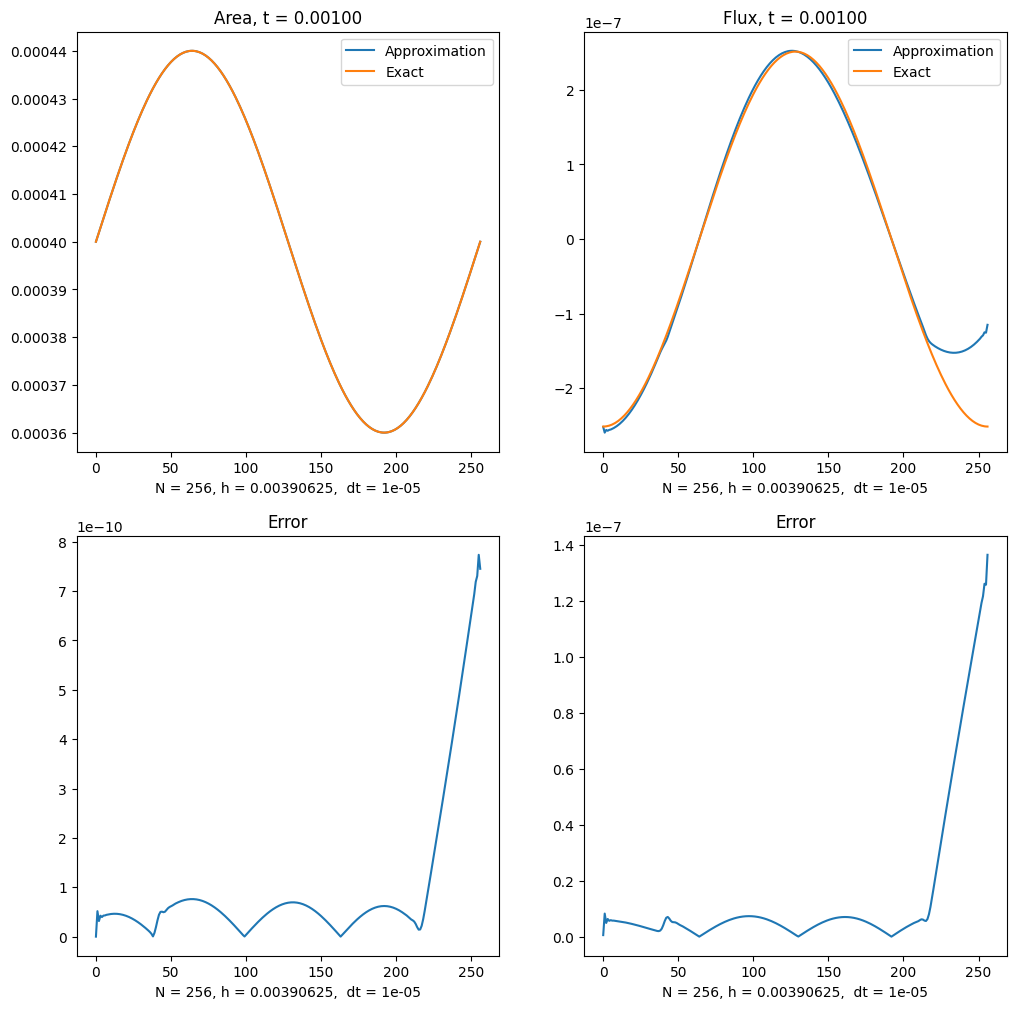

  0%|          | 100/100000 [00:10<15:42:53,  1.77it/s]

Interation 100 / 100000
t = 0.0010: error = [1.54505449e-09 3.11469716e-08]
Global error A = 1.5565514405670312e-09, Global error q = 3.1146971578831666e-08



  0%|          | 198/100000 [00:17<1:44:09, 15.97it/s]

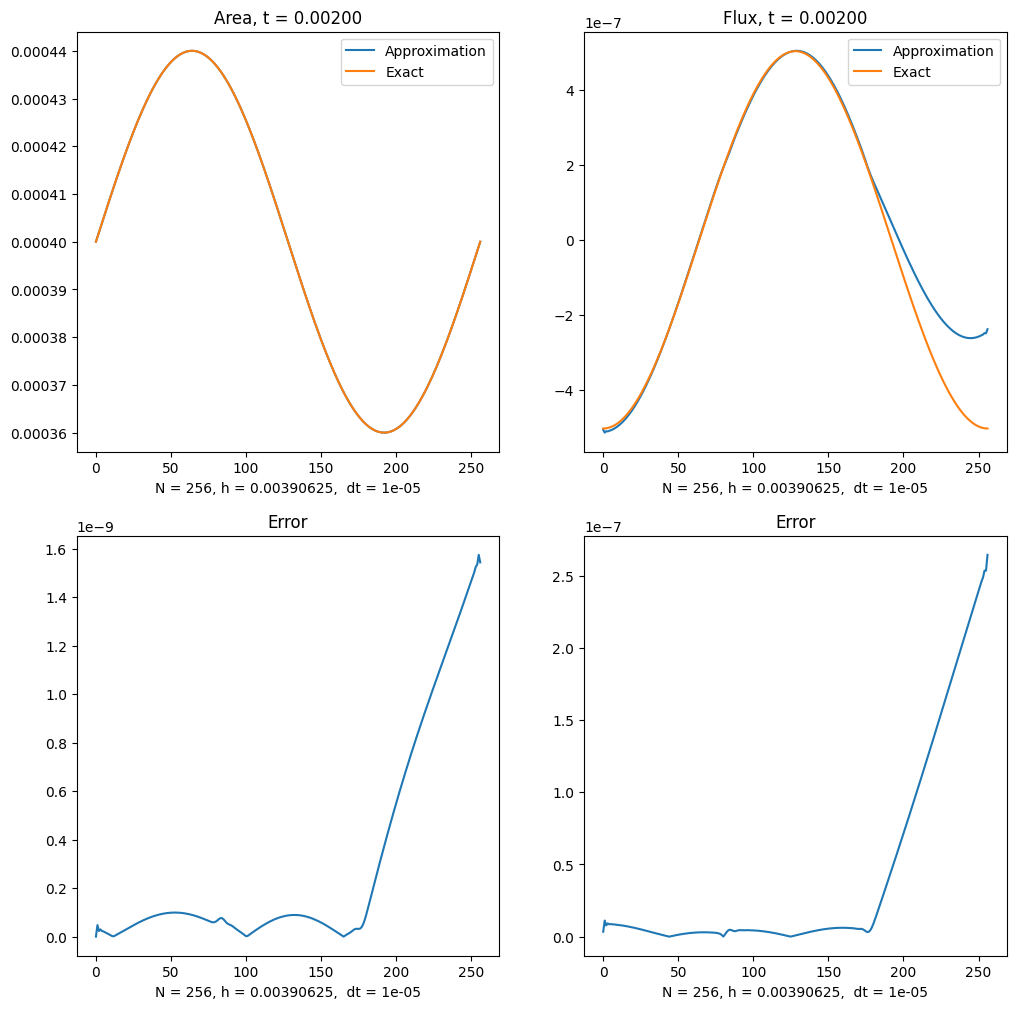

  0%|          | 202/100000 [00:18<4:15:15,  6.52it/s]

Interation 200 / 100000
t = 0.0020: error = [1.48317644e-09 8.22267668e-08]
Global error A = 1.5565514405670312e-09, Global error q = 8.22267667525703e-08



  0%|          | 298/100000 [00:24<2:23:10, 11.61it/s]

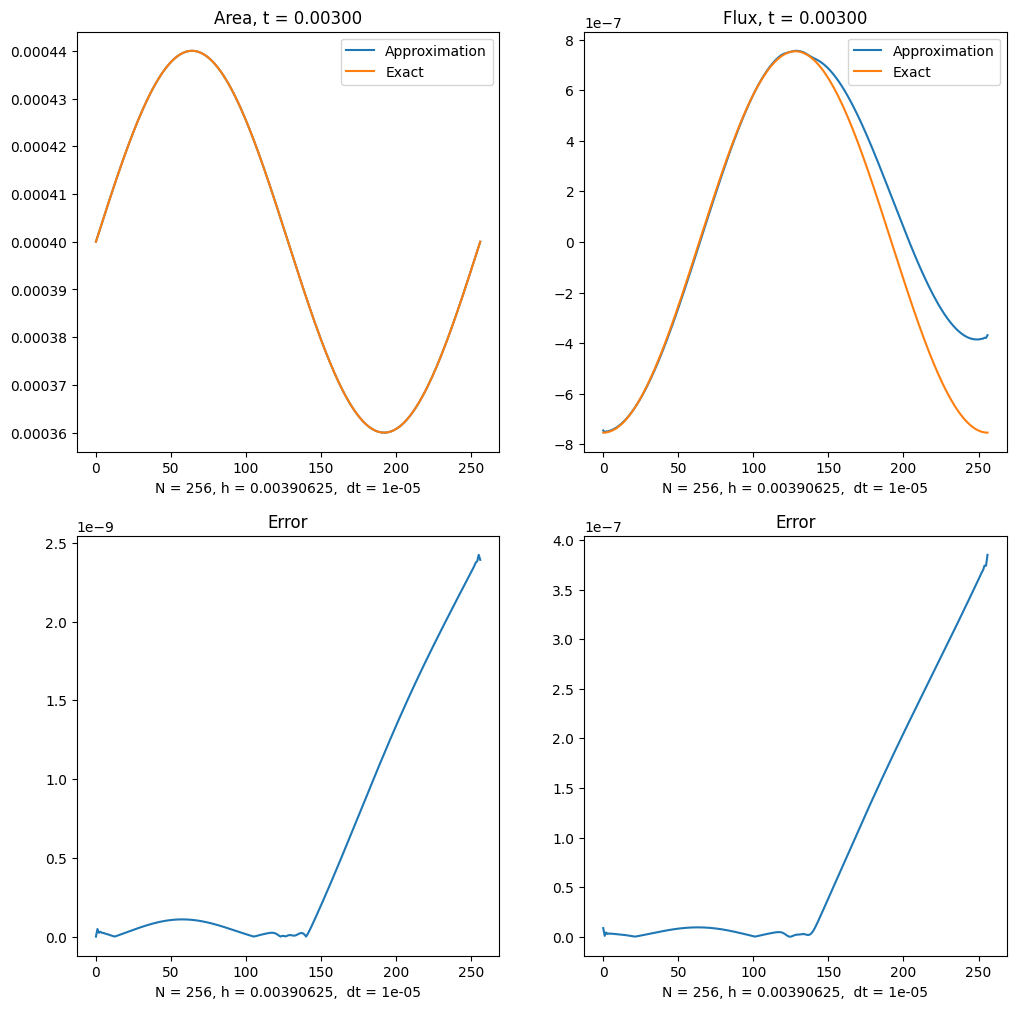

  0%|          | 300/100000 [00:26<8:26:46,  3.28it/s]

Interation 300 / 100000
t = 0.0030: error = [1.41264696e-09 1.50418055e-07]
Global error A = 1.5565514405670312e-09, Global error q = 1.504180545660447e-07



  0%|          | 398/100000 [00:33<1:40:08, 16.58it/s]

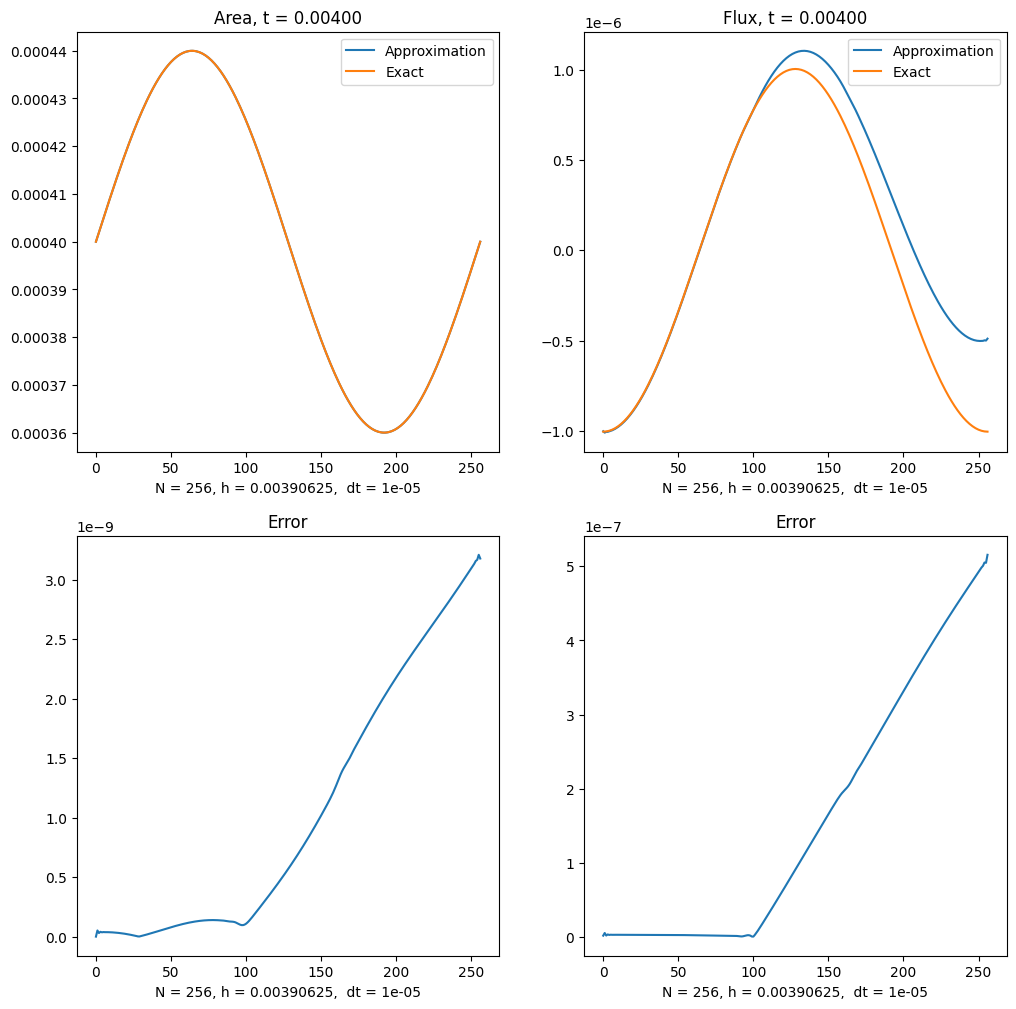

  0%|          | 402/100000 [00:34<4:10:26,  6.63it/s]

Interation 400 / 100000
t = 0.0040: error = [1.49791585e-09 2.32022719e-07]
Global error A = 1.5565514405670312e-09, Global error q = 2.320227191113074e-07



  0%|          | 407/100000 [00:34<2:21:18, 11.75it/s]


KeyboardInterrupt: 

In [226]:
# Time stepping
uh = Function(V)
#q_zero_mean = Function(V.sub(1).collapse())
t = 0
i = 0

global_error_A = 0
global_error_q = 0

for n in tqdm(range(round(num_steps))):

  i +=1

  # Update time step
  t = update_time_step(t, dt)
  f_n = project(f, V)
  df_dt_n = project(df_dt, V)

  # Solve the problem
  a, L = LinearProblem(Ah_old, qh_old)
  solve(a == L, uh, bc)
  Ah, qh = uh.split(deepcopy = True)

  A_ex = interpolate(A_exact, V_ex.sub(0).collapse())
  q_ex = interpolate(q_exact, V_ex.sub(1).collapse())
  #q_zero_mean.assign(qh)
  #q_zero_mean.vector()[:] -= assemble(qh*dx)/assemble(1*dx(domain=mesh))
  error = np.array([errornorm(Ah, A_ex, 'L2'), errornorm(qh, q_ex, 'L2')])

  if error[0] > global_error_A:
    global_error_A = error[0]

  if error[1] > global_error_q:
    global_error_q = error[1]

  # Compute errors
  if (i % 100 == 0):
    plot_solution()
    print(f'Interation {i} / {round(num_steps)}')
    print(f't = %.4f: error = {error}' % (t))
    print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
    print()

  # Update previous solution
  Ah_old.assign(Ah)
  qh_old.assign(qh)

  #A_inlet = 1 + t
  q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0), x_left)
  A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0), x_right)
  bc = update_bc(A_inlet, q_inlet, A_outlet, q_outlet)

print(f'N = {N}, h = {h}, dt = {dt} : Global error A = {global_error_A}, Global error q = {global_error_q}')

In [ ]:
error_A.append(global_error_A)
error_q.append(global_error_q)
error_A, error_q

# Space convergence

In [ ]:
h_vec = [1 / (2 ** i) for i in range(5, 9)]
dt = 1e-5
num_steps = T / dt

error_A = []
error_q = []

for h in h_vec:
  print(f'h = {h}, dt = {dt}')
  print()

  N = int((x_right - x_left) / h)

  mesh = IntervalMesh(N, x_left, x_right)
  x = MeshCoordinates(mesh)

  V = FunctionSpace(mesh, element)
  V_der = FunctionSpace(mesh, element_der)
  V_ex = FunctionSpace(mesh, element_exact)

  f_n = project(f, V)
  df_dt_n = project(df_dt, V)

  uh_old = interpolate(Expression(('A_tilde + a_tilde * sin(2 * pi / L * x[0])', 'q0'), degree = 2, A_tilde = A_tilde, a_tilde = a_tilde, L = L, q0 = q0), V)
  Ah_old, qh_old = uh_old.split()

  bc_A_inlet = DirichletBC(V.sub(0), A_inlet, inlet)
  bc_q_inlet = DirichletBC(V.sub(1), q_inlet, inlet)
  bc_A_outlet = DirichletBC(V.sub(0), A_outlet, outlet)
  bc_q_outlet = DirichletBC(V.sub(1), q_outlet, outlet)

  bc = [bc_A_inlet, bc_q_inlet, bc_A_outlet, bc_q_outlet]

  A, q = TrialFunctions(V)
  v, z = TestFunctions(V)

  uh = Function(V)
  t = 0
  i = 0

  global_error_A = 0
  global_error_q = 0

  for n in range(round(num_steps)):

    i +=1

    # Update time step
    t = update_time_step(t, dt)
    f_n = project(f, V)
    df_dt_n = project(df_dt, V)

    # Solve the problem
    a, L = LinearProblem(Ah_old, qh_old)
    solve(a == L, uh, bc)
    Ah, qh = uh.split(deepcopy = True)

    A_e = interpolate(A_exact, V_ex.sub(0).collapse())
    q_ex = interpolate(q_exact, V_ex.sub(1).collapse())
    q_zero_mean.assign(qh)
    q_zero_mean.vector()[:] -= assemble(qh*dx)/assemble(1*dx(domain=mesh))
    error = np.array([errornorm(Ah, A_ex, 'L2'), errornorm(q_zero_mean, q_ex, 'L2')])

    if error[0] > global_error_A:
      global_error_A = error[0]

    if error[1] > global_error_q:
      global_error_q = error[1]

    # Compute errors
    if (i % 1000 == 0):
      print(f'Interation {i} / {round(num_steps)}')
      print(f't = %.4f: error = {error}' % (t))
      print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
      print()

    if (i % 10000 == 0):
      plot_solution()

    # Update previous solution
    Ah_old.assign(Ah)
    qh_old.assign(qh)

    q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0))
    A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0))
    bc = update_bc(A_inlet, q_inlet, A_outlet, q_outlet)

  print(f'N = {N}, h = {h}, dt = {dt} : Global error A = {global_error_A}, Global error q = {global_error_q}')
  error_A.append(global_error_A)
  error_q.append(global_error_q)

In [ ]:
h_vec = np.array([1/32, 1 /64, 1/128, 1/256])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

# Plot for Area
ax[0].plot(error_A)
ax[0].set_title('Area')
ax[0].set_xlabel(f'h = {h_vec},  dt = {dt}')
ax[0].set_ylabel('Error')

ax[2].loglog(h_vec / h_vec[0], error_A / error_A[0], label = 'L^2 Error')
ax[2].loglog(h_vec / h_vec[0], h_vec / h_vec[0], linestyle = '--', label = 'h')
ax[2].loglog(h_vec / h_vec[0], (h_vec / h_vec[0])**2, linestyle = '--', label ='h^2')
ax[2].set_xlabel('h')
ax[2].set_ylabel('Error')
ax[2].set_title('Area')
ax[2].legend()

# Plot for Flux
ax[1].plot(error_q)
ax[1].set_title('Flux')
ax[1].set_xlabel(f'h = {h_vec},  dt = {dt}')
ax[1].set_ylabel('Error')

ax[3].loglog(h_vec / h_vec[0], error_q / error_q[0], label = 'L^2 Error')
ax[3].loglog(h_vec / h_vec[0], h_vec / h_vec[0], linestyle = '--', label = 'h')
ax[3].loglog(h_vec / h_vec[0], (h_vec / h_vec[0])**2, linestyle = '--', label = 'h^2')
ax[3].set_xlabel('h')
ax[3].set_ylabel('Error')
ax[3].set_title('Flux')
ax[3].legend()

# Time convergence

In [ ]:
# Time stepping
h = 1 / 32
dt_vec = 1e-4 * np.array([1, 1/2, 1/4, 1/8])
error_A = []
error_q = []

for dt in dt_vec:
  print(f'dt = {dt}')
  print()

  uh = Function(V)
  t = 0
  i = 0

  global_error_A = 0
  global_error_q = 0

  num_steps = T / dt

  for n in range(round(num_steps)):

    i +=1

    # Update time step
    t = update_time_step(t, dt)
    f_n = project(f, V)
    df_dt_n = project(df_dt, V)

    # Solve the problem
    a, L = LinearProblem(Ah_old, qh_old)
    solve(a == L, uh, bc)
    Ah, qh = uh.split(deepcopy = True)

    A_ex = interpolate(A_exact, V_ex.sub(0).collapse())
    q_ex = interpolate(q_exact, V_ex.sub(1).collapse())
    q_zero_mean.assign(qh)
    q_zero_mean.vector()[:] -= assemble(qh*dx)/assemble(1*dx(domain=mesh))
    error = np.array([errornorm(Ah, A_ex, 'L2'), errornorm(q_zero_mean, q_ex, 'L2')])

    if error[0] > global_error_A:
      global_error_A = error[0]

    if error[1] > global_error_q:
      global_error_q = error[1]

    # Compute errors
    if (i % 1000 == 0):
      print(f'Interation {i} / {round(num_steps)}')
      print(f't = %.4f: error = {error}' % (t))
      print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
      print()

    if (i % 10000 == 0):
      plot_solution()

    # Update previous solution
    Ah_old.assign(Ah)
    qh_old.assign(qh)

    q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0))
    A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0))
    bc = update_bc(A_inlet, q_inlet, A_outlet, q_outlet)

  error_A.append(global_error_A)
  error_q.append(global_error_q)

In [ ]:
dt_vec = 1e-4 * np.array([1, 1/2, 1/4, 1/8])
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

# Plot for Area
ax[0].plot(error_A)
ax[0].set_title('Area')
ax[0].set_xlabel(f'h = {h},  dt = {dt_vec}')
ax[0].set_ylabel('Error')

ax[2].loglog(dt_vec / dt_vec[0], error_A / error_A[0], label = 'L^2 Error')
ax[2].loglog(dt_vec / dt_vec[0], dt_vec / dt_vec[0], linestyle = '--', label = 'dt')
ax[2].loglog(dt_vec / dt_vec[0], (dt_vec / dt_vec[0])**2, linestyle = '--', label ='dt^2')
ax[2].set_xlabel('dt')
ax[2].set_ylabel('Error')
ax[2].set_title('Area')
ax[2].legend()

# Plot for Flux
ax[1].plot(error_q)
ax[1].set_title('Flux')
ax[1].set_xlabel(f'h = {h},  dt = {dt_vec}')
ax[1].set_ylabel('Error')

ax[3].loglog(dt_vec / dt_vec[0], error_q / error_q[0], label = 'L^2 Error')
ax[3].loglog(dt_vec / dt_vec[0], dt_vec / dt_vec[0], linestyle = '--', label = 'dt')
ax[3].loglog(dt_vec / dt_vec[0], (dt_vec / dt_vec[0])**2, linestyle = '--', label = 'dt^2')
ax[3].set_xlabel('dt')
ax[3].set_ylabel('Error')
ax[3].set_title('Flux')
ax[3].legend()